In [1]:
%config Completer.use_jedi = False
%load_ext autoreload

from collections import defaultdict
import re, time, os, shutil, json
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
import tempfile
from utils import get_label, to_numpy
from dataset import assign_feature_maps
import configdot
import torch
from monai.config import print_config
from IPython.core.debugger import set_trace
from tqdm import tqdm


%autoreload 2

In [2]:
subjects_list = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()
subjects_all = np.concatenate([subjects_list['train'], subjects_list['test']])
features_all = ['image', 
                 't2', 
                 'flair', 
                 'blurring-t1', 
                 'blurring-t2', 
                 'blurring-Flair', 
                 'cr-t2', 
                 'cr-Flair', 
                 'thickness', 
                 'curv', 
                 'sulc', 
                 'variance', 
                 'entropy']

# Plot histograms for each feature across different subjects  

In [16]:
minmax_all = {}
features_hist_all = {}

for feature in tqdm(features_all):
    
    max_values = []
    min_values = []
    # list of hists for each subj
    features_hist_list = []
    for sub in subjects_all:
        # return whole path
        fpath = assign_feature_maps(sub, feature)
        mpath = assign_feature_maps(sub, 'mask')
        fdata = nib.load(fpath).get_fdata()
        fmask = nib.load(mpath).get_fdata()
        hist, bins = np.histogram(fdata[fmask > 0], bins=50)
        
        min_values.append(fdata[fmask > 0].min())
        max_values.append(fdata[fmask > 0].max())
        
        features_hist_list.append([hist, bins])
        
    features_hist_all[feature] = features_hist_list
    minmax_all[feature] = [np.min(min_values), np.max(max_values)]     


  0%|          | 0/13 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/lib/python3.8/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/root/miniconda3/lib/python3.8/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration
100%|██████████| 13/13 [09:27<00:00, 43.62s/it]


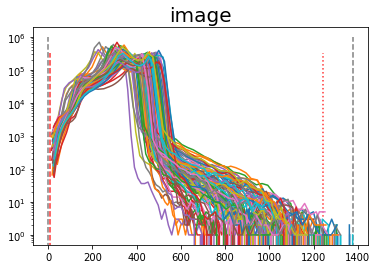

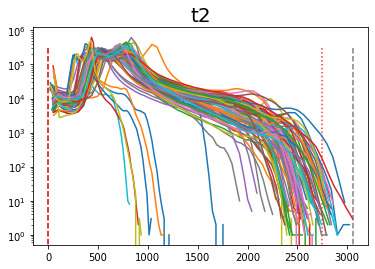

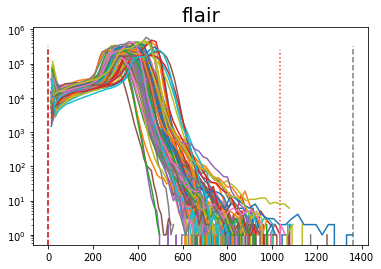

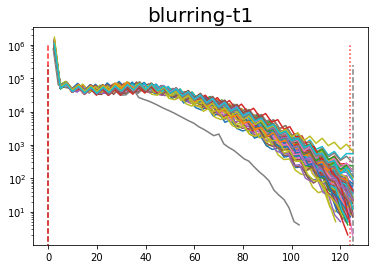

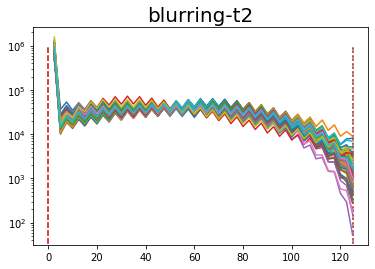

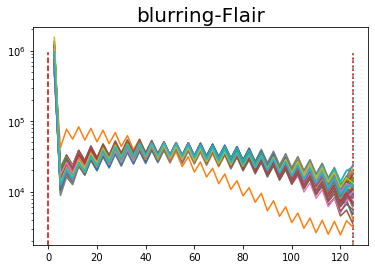

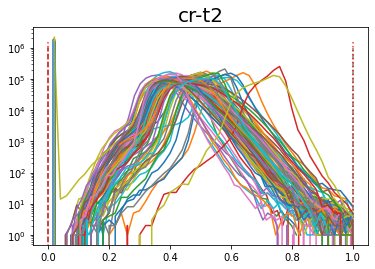

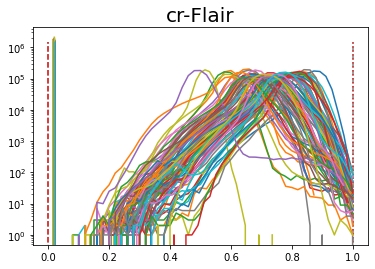

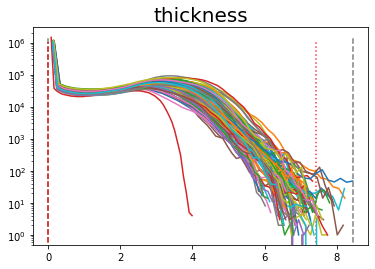

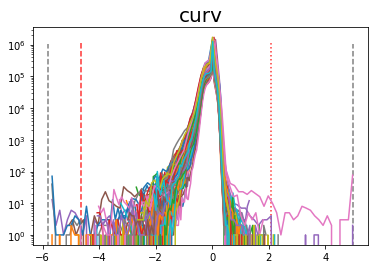

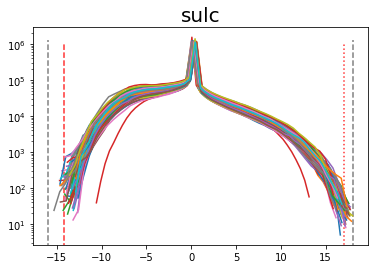

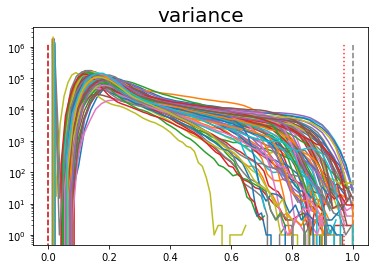

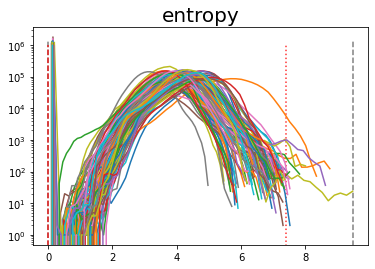

In [32]:
bins_all = defaultdict(list)
quantiles_all = {}
for feature in features_all:
    
    plt.figure()
    
    # min-max 
    plt.vlines(minmax_all[feature][0], 0, hist.max(), linestyle='--', alpha=0.5, color='black')
    plt.vlines(minmax_all[feature][1], 0, hist.max(), linestyle='--', alpha=0.5, color='black')
    
    for k, (hist, bins) in enumerate(features_hist_all[feature]):
        plt.plot(bins[1:], hist)
        bins_all[feature].append(bins)
    bins_all[feature] = np.concatenate(bins_all[feature])
    
    # quantiles
    q_min = np.quantile(bins_all[feature], q=0.01)
    q_max = np.quantile(bins_all[feature], q=0.99)
    plt.vlines(q_min, 0, hist.max(), linestyle='--', alpha=0.8, color='red')
    plt.vlines(q_max, 0, hist.max(), linestyle='dotted', alpha=0.8, color='red')
    quantiles_all[feature] = [q_min, q_max]
    
    plt.yscale('log')
    plt.title(feature, fontsize=20)
    plt.show()


In [7]:
scaling_data_path = 'metadata/minmax_scaling_metadata.npy'
np.save(scaling_data_path, minmax_all)

quntiles_data_path = 'metadata/quantiles_metadata.npy'
np.save(quntiles_data_path, quantiles_all)

# Amend outliers

In [ ]:
# feature = 'curv'
# # list of hists for each subj
# for sub in tqdm(subjects_all):
#     # return whole path
#     fpath = assign_feature_maps(sub, feature)
#     fnib = nib.load(fpath)
#     fdata = fnib.get_fdata()
#     fdata_ = np.clip(fdata, a_min=q_min, a_max=q_max)
    
#     # fpath_tmp = os.path.join('./tmp', ''.join(fpath.split('/')[-2:]))
    
#     final_img = nib.Nifti1Image(fdata_, fnib.affine)
#     nib.save(final_img, fpath)
    

In [ ]:
# sub_anom = 'n50'
# fdata_anom = nib.load(assign_feature_maps(sub_anom, 'curv')).get_fdata()
# fmask_anom = nib.load(assign_feature_maps(sub_anom, 'mask')).get_fdata()
# hist, bins = np.histogram(fdata_anom[fmask_anom > 0], bins=50)

In [ ]:
# fdata_anom_ = np.clip(fdata_anom, a_min=q_min, a_max=q_max)
# hist_, bins_ = np.histogram(fdata_anom_[fmask_anom > 0], bins=50)
# plt.plot(bins[1:], hist)
# plt.plot(bins_[1:], hist_, color='red')
# plt.yscale('log')
# plt.show()

In [ ]:
# total_pixnum = np.prod(fdata_anom.shape)
# nonzero_pixnum = fdata_anom[np.abs(fdata_anom) > 1e-3].shape[0]
# anom_pixnum = fdata_anom[fdata_anom > 1].shape[0]
# anom_pixnum / nonzero_pixnum